This is the documentation for "Evaluating the Effectiveness of Algorithms for EEG Sentiment Analysis" paper by

1.   Sumya Akter
2.   Rumman Ahmed Prodhan
1.   Muhammad Bin Mujib
2.   Md. Akhtaruzzaman Adnan
2.   Tanmoy Sarkar Pias (Corresponding Author)









**Pyeeg has been installed**

In [ ]:
pip install git+https://github.com/forrestbao/pyeeg.git

  Cloning https://github.com/forrestbao/pyeeg.git to /tmp/pip-req-build-07jc0q14
  Running command git clone -q https://github.com/forrestbao/pyeeg.git /tmp/pip-req-build-07jc0q14
  Created wheel for pyeeg: filename=pyeeg-0.4.4-py2.py3-none-any.whl size=28131 sha256=470a97d728dd6f8b7dea65293272e7a5340fcca881d3f2f082954f2e724dfa4e
  Stored in directory: /tmp/pip-ephem-wheel-cache-gfzaz2ot/wheels/b0/23/e4/703c908bda656959957029fa145879aa79307b2545a2ef0271
Successfully built pyeeg


**Here is the code for mounting google drive**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install pyeeg

**Imported the necessery library packages**

In [ ]:
import numpy as np
import pyeeg as pe
import pickle as pickle
import pandas as pd
import math

from sklearn import svm
from sklearn.preprocessing import normalize

import os
import time

**Location of dat file and location for where to save preprocessed npy files**

In [ ]:
path_to_dataset_2 = '/content/drive/Shareddrives/DEAP EEG/Dataset/physiological_recordings/data_preprocessed_python/' #Location of dat file of DEAP dataset
path_to_dataset = '/content/drive/Shareddrives/DEAP EEG/Preprocessed_data/' #where to save preprocessed npy files

**Intialize the channel array, band array, window_size, step_size and sample_rate and set the path of dataset of google drive.**

In [ ]:
channel = [1,2,3,4,6,11,13,17,19,20,21,25,29,31] #14 Channels chosen to fit Emotiv Epoch+

band = [4,8,12,16,25,45] #5 bands

window_size = 256 #Averaging band power of 2 sec

step_size = 16 #Each 0.125 sec update once

sample_rate = 128 #Sampling rate of 128 Hz

subjectList=[] #taking an empty array to store subject numbers here
for i in range(1,33):
  if i<10:
     subjectList.append(f"{i:02d}") #to add extra '0' infront of 1 to 9 single digits
  else:
    subjectList.append(f"{i:2d}")


**Declaring FFT function. Taking the preprocessed dat file and converting it to a preprocessed npy file after FFT**

In [ ]:
def FFT_Processing (sub, channel, band, window_size, step_size, sample_rate):
    '''
    arguments:  string subject
                list channel indice
                list band
                int window size for FFT
                int step size for FFT
                int sample rate for FFT
    return:     void
    '''
    meta = []
    with open(path_to_dataset_2+'s' + sub + '.dat', 'rb') as file:

        subject = pickle.load(file, encoding='latin1') #resolve the python 2 data problem by encoding : latin1

        for i in range (0,40):
            # loop over 0-39 trails
            data = subject["data"][i]
            labels = subject["labels"][i]
            start = 0;

            while start + window_size < data.shape[1]:
                meta_array = []
                meta_data = [] #meta vector for analysis
                for j in channel:
                    X = data[j][start : start + window_size] #Slice raw data over 2 sec, at interval of 0.125 sec
                    Y = pe.bin_power(X, band, sample_rate) #FFT over 2 sec of channel j, in seq of theta, alpha, low beta, high beta, gamma
                    meta_data = meta_data + list(Y[0])

                meta_array.append(np.array(meta_data))
                meta_array.append(labels)

                meta.append(np.array(meta_array))    
                start = start + step_size
                
        meta = np.array(meta)
        np.save(path_to_dataset+'s' + sub, meta, allow_pickle=True, fix_imports=True) #saving each of the 32 files as npy after preprocessing

**Calling the FFT functions for each subjects**

In [ ]:
for subjects in subjectList:
    FFT_Processing (subjects, channel, band, window_size, step_size, sample_rate)

In [ ]:
import numpy as np
# save np.load
np_load_old = np.load

# modify the default parameters of np.load
np.load = lambda *a,**k: np_load_old(*a, allow_pickle=True, **k)

##Dividing the Data into Training and Testing


#spliting and appending each npy into training, testing (75/25)
Dividing the 32 preprocessed npy file into data training, label training, data testing and label testing. Every npy file has 19520 rows and 4 columns which are valence, arousal, dominace and likings. Every npy file was divided by 4.

For each npy file

*   Training : 19520-4880=14640 (75%)
*   Testing : 19520/4=4880 (25%)

For training and testing
* The data training and label training both has 14640*32=468480 rows (75%)
* The data testing and label testing both has 4880*32=156160 rows (25%)









In [ ]:
data_training = []
label_training = []
data_testing = []
label_testing = []

for subjects in subjectList:

    with open(path_to_dataset + 's' + subjects + '.npy', 'rb') as file: 
        sub = np.load(file) # loading npy file
        for i in range (0,sub.shape[0]): # running loop over 19520 rows
            if i % 4 == 0: # 19520/4=4880 (25%)
                data_testing.append(sub[i][0])
                label_testing.append(sub[i][1])
            else: # 19520-4880=14640 (75%)
                data_training.append(sub[i][0])
                label_training.append(sub[i][1])

In [ ]:
# restore np.load for future normal usage
np.load = np_load_old

**Saving the data training, label training, data testing and label testing into google drive**


In [ ]:
np.save(path_to_dataset + 'data_training', np.array(data_training), allow_pickle=True, fix_imports=True)
np.save(path_to_dataset + 'label_training', np.array(label_training), allow_pickle=True, fix_imports=True)
print("training dataset:", np.array(data_training).shape, np.array(label_training).shape)

np.save(path_to_dataset + 'data_testing', np.array(data_testing), allow_pickle=True, fix_imports=True)
np.save(path_to_dataset + 'label_testing', np.array(label_testing), allow_pickle=True, fix_imports=True)
print("testing dataset:", np.array(data_testing).shape, np.array(label_testing).shape)

training dataset: (468480, 70) (468480, 4)
testing dataset: (156160, 70) (156160, 4)


**Here all the training file have been loaded .The data have been put in variable X and label values have been put in Y.Then the X has been Normalized and then valence label values have been loaded in Z. And then all the '9' values are converted into '8.99' of valence label.**

In [ ]:
with open(path_to_dataset + 'data_training.npy', 'rb') as fileTrain:
    X  = np.load(fileTrain)
    
with open(path_to_dataset + 'label_training.npy', 'rb') as fileTrainL:
    Y  = np.load(fileTrainL)
    
X = normalize(X)
Z = np.ravel(Y[:, [0]])

Valence_Train = np.ravel(Y[:, [0]])
Arousal_Train = np.ravel(Y[:, [1]])
Domain_Train = np.ravel(Y[:, [2]])
Like_Train = np.ravel(Y[:, [3]])

for i in range(len(Z)):
  if Z[i] == 9:
    Z[i] = 8.99

**All the training label values are divided into two segments. One segment contains values from 1 - 4.9 and another contains rest of the range's values. This approch is maintained for valence, arousal, dominance, likings binary classifications but not for other class classification.**


In [ ]:
count_0 = 0
count_1 = 0
for i in range(len(Z)):
  if Z[i] >= 1 and Z[i]<=4.99:
    Z [i] = 0
    count_0 = count_0 + 1
  else:
    Z [i] = 1
    count_1 = count_1 + 1
print(count_0,count_1)

203496 264984


**Necessery libraries are imported**


In [ ]:
import pandas as pd
import keras.backend as K
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense
from keras.layers.convolutional import Conv1D
from tensorflow.keras.utils import to_categorical 
from keras.layers import Flatten
from keras.layers import Dense
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras import backend as K
from keras.models import Model
import timeit
from keras.layers.core import Flatten, Dense, Dropout
from keras.layers.convolutional import Convolution1D, MaxPooling1D, ZeroPadding1D
import warnings
warnings.filterwarnings('ignore')

**Here all the training label values are categorised. For binary classification and it is catagorised into two catagory. value range 1 - 4.99 have been assigned in catagory '0' and rest of the value are assigned in catagory '1'.** 

1.  1-4.99 ----> catagory(0)
2.  5-8.99 ----> catagory(1)

In [ ]:
y_train = to_categorical(Z)
y_train[:10]

array([[0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.]], dtype=float32)

**Values of X are put in x_train as numpy array format**

In [ ]:
x_train = np.array(X[:])

**Here all the testing file have been loaded .The data have been put in variable M and label values have been put in N.Then the M has been Normalized and then valence label values have been loaded in L. And then all the '9' values are converted into '8.99' of valence label.**

In [ ]:
with open(path_to_dataset + 'data_testing.npy', 'rb') as fileTrain:
    M  = np.load(fileTrain)
    
with open(path_to_dataset + 'label_testing.npy', 'rb') as fileTrainL:
    N  = np.load(fileTrainL)

M = normalize(M)
L = np.ravel(N[:, [0]])


Valence_Test = np.ravel(N[:, [0]])
Arousal_Test = np.ravel(N[:, [1]])
Domain_Test = np.ravel(N[:, [2]])
Like_Test = np.ravel(N[:, [3]])

for i in range(len(L)):
  if L[i] == 9:
    L[i] = 8.99

**All the testing labels values are divided into two segments. One segment contains values from 1 - 4.9 and another contains rest of the range's values. This approch is maintained for valence, arousal, dominance, likings binary classifications but not for other class classification.**

In [ ]:
count_0 = 0
count_1 = 0
for i in range(len(L)):
  if L[i] >= 1 and L[i]<=4.99:
    L [i] = 0
    count_0 = count_0 + 1
  else:
    L [i] = 1
    count_1 = count_1 + 1
print(count_0,count_1)

67832 88328


**Vules of M are assigned in x_test in numpy array format**

In [ ]:
x_test = np.array(M[:])
x_test

array([[0.07006464, 0.10438554, 0.06634758, ..., 0.10698754, 0.14264875,
        0.12007955],
       [0.07695878, 0.10655808, 0.05897592, ..., 0.09381841, 0.14959873,
        0.12751455],
       [0.07546743, 0.08606705, 0.07999725, ..., 0.12147734, 0.13970255,
        0.12824657],
       ...,
       [0.1897225 , 0.11085076, 0.04970787, ..., 0.02452725, 0.05530559,
        0.06475889],
       [0.17817637, 0.08834064, 0.05389381, ..., 0.03475489, 0.05801423,
        0.06873259],
       [0.14543648, 0.08345535, 0.04799341, ..., 0.02695435, 0.06128512,
        0.07725748]])

**Here all the tessting labels values are categorised. For binary classification and it is catagorised into two catagory. value range 1 - 4.99 have been assigned in catagory '0' and rest of the value are assigned in catagory '1'.**

* 1-4.99 ----> catagory(0)
* 5-8.99 ----> catagory(1)

In [ ]:
from tensorflow.keras.utils import to_categorical 
y_test = to_categorical(L)

**Fit the train and test data with StandarScaler**

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.fit_transform(x_test)

**Two dimensional data are converted into three dimension by adding one constant dimension’s value '1'. This is for CNN, LSTM and Bi-LSTM only**

In [ ]:
x_train = x_train.reshape(x_train.shape[0],x_train.shape[1], 1)
x_test = x_test.reshape(x_test.shape[0],x_test.shape[1], 1)

**Here define the batch_size, number of class used in model architecture ,how many epoch will be run with the model and also define the input_shape. This is for CNN, LSTM and Bi-LSTM only**

In [ ]:
batch_size = 256
num_classes = 2
epochs = 100

input_shape=(x_train.shape[1], 1)

**import another library packages**

In [ ]:
from keras.layers import Convolution1D, ZeroPadding1D, MaxPooling1D, BatchNormalization, Activation, Dropout, Flatten, Dense
from keras.regularizers import l2
from keras.layers import Input
from keras.layers.merge import concatenate
from keras.layers import Input
from keras.layers.merge import concatenate
from keras.utils.vis_utils import plot_model

# Deep Learning Algorithms

##CNN Model with Residual Connection

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 70, 1)]      0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 70, 1024)     7168        ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 70, 1024)    4096        ['conv1d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 max_pooling1d (MaxPooling1D)   (None, 35, 1024)     0           ['batch_normalization[0][0]']

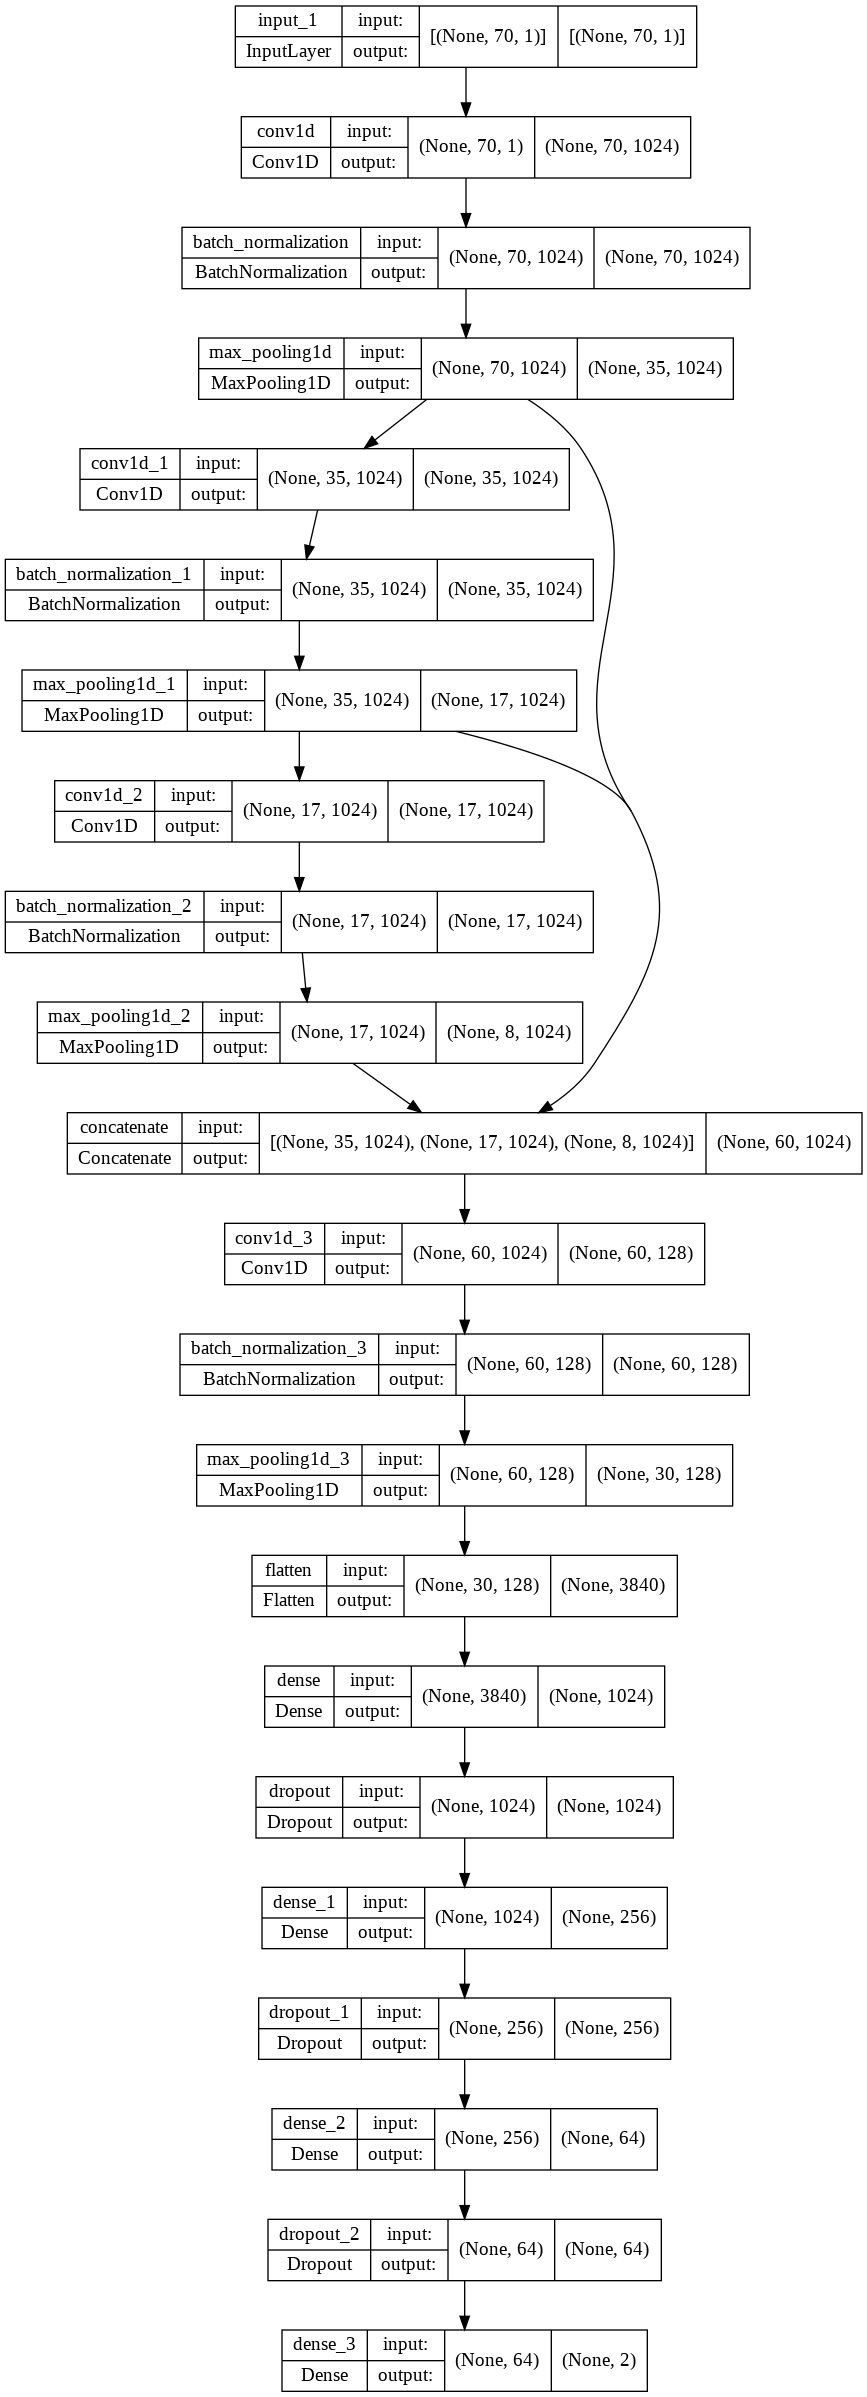

In [ ]:
from keras.layers import Input
from keras.layers.merge import concatenate
from keras.utils.vis_utils import plot_model


intput_shape=(70, 1) #x_train.shape[1]

input_layer = Input(intput_shape)

conv1 = Conv1D(1024, kernel_size=6,padding = 'same',activation='relu') (input_layer)
bn1 = BatchNormalization() (conv1)
pool1 = MaxPooling1D(pool_size=(2)) (bn1)

conv2 = Conv1D(1024,kernel_size=6,padding = 'same', activation='relu') (pool1)
bn2 = BatchNormalization() (conv2) 
pool2 = MaxPooling1D(pool_size=(2)) (bn2)


conv3 = Conv1D(1024,kernel_size=6,padding = 'same', activation='relu') (pool2)
bn3 = BatchNormalization() (conv3)
pool3 = MaxPooling1D(pool_size=(2)) (bn3)

connect1 = concatenate([pool1, pool2, pool3], axis=1)

conv4 = Conv1D(128,kernel_size=6,padding = 'same', activation='relu') (connect1)
bn4 = BatchNormalization() (conv4)
pool4 = MaxPooling1D(pool_size=(2)) (bn4)

flat = Flatten() (pool4)

dense1 = Dense(1024, activation='relu') (flat)
drop1 = Dropout(0.2) (dense1)

dense2 = Dense(256, activation='relu') (drop1)
drop2 = Dropout(0.2) (dense2)

dense3 = Dense(64, activation='relu') (drop2)
drop3 = Dropout(0.2) (dense3)

output_layer = Dense(2, activation='softmax') (drop3) #num_classes

model = Model(input_layer, output_layer)
model.summary()
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

**Compiling the model**

In [ ]:
model.compile(loss=keras.losses.categorical_crossentropy, 
              optimizer='adam',
              metrics=['accuracy'])

**Automatic save 
(We have saved all the details of every epoch in google drive so that we can use this when we need.)**


In [ ]:
# check points and early stopping
from keras.callbacks import ModelCheckpoint,EarlyStopping

model_name = ""
filepath="/content/drive/Shareddrives/DEAP EEG/Models Saved/Valence/CNN_algorithm_model2/"  + model_name + "weights-improvement-{epoch:02d}-{accuracy:.4f}.hdf5"
print(filepath)
checkpoint = ModelCheckpoint(filepath, monitor='accuracy', verbose=1, save_best_only=True, mode='max')
es = EarlyStopping(monitor='accuracy', mode='max', verbose=1, patience=50)
callbacks_list = [es, checkpoint]

/content/drive/Shareddrives/DEAP EEG/Models Saved/Valence/CNN_algorithm_model2/weights-improvement-{epoch:02d}-{accuracy:.4f}.hdf5


**Fit the model**


In [ ]:
H = model.fit(x_train, y_train,
          batch_size=100,
          epochs=100,
          verbose=1,
          callbacks= callbacks_list)

Epoch 1/100
4685/4685 [==============================] - ETA: 0s - loss: 0.6147 - accuracy: 0.6477
Epoch 1: accuracy improved from -inf to 0.64768, saving model to /content/drive/Shareddrives/DEAP EEG/Models Saved/Valence/CNN_algorithm_model2/weights-improvement-01-0.6477.hdf5
4685/4685 [==============================] - 425s 88ms/step - loss: 0.6147 - accuracy: 0.6477
Epoch 2/100
4685/4685 [==============================] - ETA: 0s - loss: 0.5217 - accuracy: 0.7252
Epoch 2: accuracy improved from 0.64768 to 0.72517, saving model to /content/drive/Shareddrives/DEAP EEG/Models Saved/Valence/CNN_algorithm_model2/weights-improvement-02-0.7252.hdf5
4685/4685 [==============================] - 414s 88ms/step - loss: 0.5217 - accuracy: 0.7252
Epoch 3/100
4685/4685 [==============================] - ETA: 0s - loss: 0.4230 - accuracy: 0.7899
Epoch 3: accuracy improved from 0.72517 to 0.78992, saving model to /content/drive/Shareddrives/DEAP EEG/Models Saved/Valence/CNN_algorithm_model2/weights

**Evaluating the CNN model testing accuracy**

In [ ]:
score = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

4880/4880 [==============================] - 56s 11ms/step - loss: 0.1501 - accuracy: 0.9664
Test loss: 0.1500704139471054
Test accuracy: 0.9664126634597778


**Loading the saved weights of CNN model**

In [ ]:
from keras.models import load_model
model_loaded = load_model('/content/drive/Shareddrives/DEAP EEG/Models Saved/Valence/CNN_algorithm_model2/weights-improvement-99-0.9917.hdf5')
score = model_loaded.evaluate(x_test, y_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

4880/4880 [==============================] - 62s 11ms/step - loss: 0.1572 - accuracy: 0.9686
Test loss: 0.15724389255046844
Test accuracy: 0.9685899019241333


In [ ]:
y_true = np.array(y_test)
y_pred = model_loaded.predict(x_test)

**Classification report of CNN model**

In [ ]:
y_pred = np.squeeze(y_pred)
y_pred = np.array(y_pred >= 0.5, dtype=np.int)

from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.97      0.96     67832
           1       0.97      0.97      0.97     88328

   micro avg       0.97      0.97      0.97    156160
   macro avg       0.97      0.97      0.97    156160
weighted avg       0.97      0.97      0.97    156160
 samples avg       0.97      0.97      0.97    156160



## LSTM

In [ ]:
# LSTM Examples: https://keras.io/examples/nlp/bidirectional_lstm_imdb/
# https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/ 
# LSTM for international airline passengers problem with time step regression framing
import numpy
import matplotlib.pyplot as plt
from pandas import read_csv
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

# reshape input to be [samples, time steps, features]
#trainX = numpy.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
#testX = numpy.reshape(testX, (testX.shape[0], testX.shape[1], 1))

# create and fit the LSTM network
model = Sequential()
model.add(LSTM(100, input_shape=(70,1), return_sequences=True))
model.add(LSTM(100))
model.add(Dense(20))
model.add(Dense(2))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=["accuracy"])
model.fit(x_train, y_train, epochs=100, batch_size=100, verbose=1)

Epoch 1/100
4685/4685 [==============================] - 64s 12ms/step - loss: 0.6715 - accuracy: 0.5892
Epoch 2/100
4685/4685 [==============================] - 64s 14ms/step - loss: 0.6379 - accuracy: 0.6289
Epoch 3/100
4685/4685 [==============================] - 60s 13ms/step - loss: 0.6318 - accuracy: 0.6362
Epoch 4/100
4685/4685 [==============================] - 53s 11ms/step - loss: 0.6239 - accuracy: 0.6453
Epoch 5/100
4685/4685 [==============================] - 54s 11ms/step - loss: 0.6093 - accuracy: 0.6582
Epoch 6/100
4685/4685 [==============================] - 60s 13ms/step - loss: 0.6169 - accuracy: 0.6523
Epoch 7/100
4685/4685 [==============================] - 52s 11ms/step - loss: 0.6140 - accuracy: 0.6549
Epoch 8/100
4685/4685 [==============================] - 53s 11ms/step - loss: 0.5977 - accuracy: 0.6701
Epoch 9/100
4685/4685 [==============================] - 53s 11ms/step - loss: 0.5851 - accuracy: 0.6810
Epoch 10/100
4685/4685 [==============================]

**Saving the final weights of LSTM after 100 epochs**

In [ ]:
# save the model to disk
filename = '/content/drive/Shareddrives/DEAP EEG/Models Saved/Valence/LSTM/model_save.h5'
model.save(filename)

**Accuracy of LSTM after 100 epochs**

In [ ]:
score = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

4880/4880 [==============================] - 22s 4ms/step - loss: 0.4690 - accuracy: 0.7744
Test loss: 0.4689950942993164
Test accuracy: 0.7744172811508179


**2nd run (100-200 epochs)**

In [ ]:
from keras.models import load_model
model_loaded = load_model('/content/drive/Shareddrives/DEAP EEG/Models Saved/Valence/LSTM/model_save.h5')

H = model_loaded.fit(x_train, y_train, epochs=100, batch_size=100, verbose=1)

Epoch 1/100
4685/4685 [==============================] - 62s 11ms/step - loss: 0.5211 - accuracy: 0.7398
Epoch 2/100
4685/4685 [==============================] - 52s 11ms/step - loss: 0.4555 - accuracy: 0.7818
Epoch 3/100
4685/4685 [==============================] - 52s 11ms/step - loss: 0.4734 - accuracy: 0.7731
Epoch 4/100
4685/4685 [==============================] - 52s 11ms/step - loss: 0.4721 - accuracy: 0.7738
Epoch 5/100
4685/4685 [==============================] - 52s 11ms/step - loss: 0.4629 - accuracy: 0.7781
Epoch 6/100
4685/4685 [==============================] - 52s 11ms/step - loss: 0.4614 - accuracy: 0.7832
Epoch 7/100
4685/4685 [==============================] - 51s 11ms/step - loss: 0.4431 - accuracy: 0.7907
Epoch 8/100
4685/4685 [==============================] - 51s 11ms/step - loss: 0.4363 - accuracy: 0.7948
Epoch 9/100
4685/4685 [==============================] - 51s 11ms/step - loss: 0.4351 - accuracy: 0.7964
Epoch 10/100
4685/4685 [==============================]

**Accuracy of LSTM after 200 epochs**

In [ ]:
score = model_loaded.evaluate(x_test, y_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

4880/4880 [==============================] - 23s 5ms/step - loss: 0.4630 - accuracy: 0.7920
Test loss: 0.46303796768188477
Test accuracy: 0.7920466065406799


**Loading the LSTM model of 100epochs from google drive**

In [ ]:
from keras.models import load_model
model_loaded = load_model('/content/drive/Shareddrives/DEAP EEG/Models Saved/Valence/LSTM/model_save.h5')
score = model_loaded.evaluate(x_test, y_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

4880/4880 [==============================] - 23s 5ms/step - loss: 0.4690 - accuracy: 0.7744
Test loss: 0.4689950942993164
Test accuracy: 0.7744172811508179


In [ ]:
y_true = np.array(y_test)
y_pred = model_loaded.predict(x_test)

**Classification report of LSTM model after 100epochs**

In [ ]:
y_pred = np.squeeze(y_pred)
y_pred = np.array(y_pred >= 0.5, dtype=np.int)

from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.75      0.72      0.73     67832
           1       0.78      0.83      0.80     88328

   micro avg       0.77      0.78      0.78    156160
   macro avg       0.77      0.77      0.77    156160
weighted avg       0.77      0.78      0.77    156160
 samples avg       0.77      0.78      0.77    156160



## Bi-LSTM

In [ ]:
# LSTM Examples: https://keras.io/examples/nlp/bidirectional_lstm_imdb/
# https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/ 
# LSTM for international airline passengers problem with time step regression framing
# Bi-LSTM https://analyticsindiamag.com/complete-guide-to-bidirectional-lstm-with-python-codes/#:~:text=Bidirectional%20long%2Dshort%20term%20memory(bi%2Dlstm)%20is,different%20from%20the%20regular%20LSTM.
import numpy
import matplotlib.pyplot as plt
from pandas import read_csv
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.layers import Dropout, Embedding, Bidirectional

# reshape input to be [samples, time steps, features]
#trainX = numpy.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
#testX = numpy.reshape(testX, (testX.shape[0], testX.shape[1], 1))

# create and fit the LSTM network
model = Sequential()
model.add(Bidirectional(LSTM(100, input_shape=(70,1), return_sequences=True)))
model.add(Bidirectional(LSTM(100)))
model.add(Dense(20))
model.add(Dense(2))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=["accuracy"])
model.fit(x_train, y_train, epochs=100, batch_size=100, verbose=1)

Epoch 1/100
4685/4685 [==============================] - 131s 25ms/step - loss: 0.6758 - accuracy: 0.5873
Epoch 2/100
4685/4685 [==============================] - 127s 27ms/step - loss: 0.6478 - accuracy: 0.6169
Epoch 3/100
4685/4685 [==============================] - 119s 25ms/step - loss: 0.6418 - accuracy: 0.6264
Epoch 4/100
4685/4685 [==============================] - 118s 25ms/step - loss: 0.6428 - accuracy: 0.6270
Epoch 5/100
4685/4685 [==============================] - 118s 25ms/step - loss: 0.6306 - accuracy: 0.6388
Epoch 6/100
4685/4685 [==============================] - 118s 25ms/step - loss: 0.6300 - accuracy: 0.6409
Epoch 7/100
4685/4685 [==============================] - 118s 25ms/step - loss: 0.6141 - accuracy: 0.6559
Epoch 8/100
4685/4685 [==============================] - 118s 25ms/step - loss: 0.6233 - accuracy: 0.6459
Epoch 9/100
4685/4685 [==============================] - 118s 25ms/step - loss: 0.6047 - accuracy: 0.6645
Epoch 10/100
4685/4685 [======================

**Saving the final weights of Bi-LSTM after 100 epochs to google drive**

In [ ]:
# save the model to disk
filename = '/content/drive/Shareddrives/DEAP EEG/Models Saved/Valence/Bi_LSTM/bilstm_model_weights_epochs_100.h5'
model.save(filename)

**Testing Accuracy of Bi-LSTM after 100 epochs**

In [ ]:
score = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

4880/4880 [==============================] - 43s 8ms/step - loss: 0.4714 - accuracy: 0.7755
Test loss: 0.47144263982772827
Test accuracy: 0.775531530380249


**Loading the Bi-LSTM model of 100epochs from google drive**

In [ ]:
from keras.models import load_model
model_loaded = load_model('/content/drive/Shareddrives/DEAP EEG/Models Saved/Valence/Bi_LSTM/bilstm_model_weights_epochs_100.h5')
score = model_loaded.evaluate(x_test, y_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

4880/4880 [==============================] - 37s 7ms/step - loss: 0.4714 - accuracy: 0.7755
Test loss: 0.47144263982772827
Test accuracy: 0.775531530380249


In [ ]:
y_true = np.array(y_test)
y_pred = model_loaded.predict(x_test)

**Classification report of Bi-LSTM after 100 epochs**

In [ ]:
y_pred = np.squeeze(y_pred)
y_pred = np.array(y_pred >= 0.5, dtype=np.int)

from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.74      0.74      0.74     67832
           1       0.80      0.80      0.80     88328

   micro avg       0.78      0.77      0.77    156160
   macro avg       0.77      0.77      0.77    156160
weighted avg       0.78      0.77      0.77    156160
 samples avg       0.76      0.77      0.77    156160



# Machine Learning Algorithms

## SVM

In [ ]:
# import SVC classifier
from sklearn.svm import SVC
# import metrics to compute accuracy
from sklearn.metrics import accuracy_score


# instantiate classifier with default hyperparameters
svc=SVC() 


In [ ]:
# import SVC classifier
from sklearn.svm import SVC
# import metrics to compute accuracy
from sklearn.metrics import accuracy_score


# instantiate classifier with default hyperparameters
svc=SVC() 


# fit classifier to training set
svc.fit(x_train,Z) #from label training the valence label values have been loaded in Z


# make predictions on test set
y_pred=svc.predict(x_test)

In [ ]:
print('Model accuracy score with default hyperparameters: {0:0.4f}'. format(accuracy_score(L, y_pred))) ##from label testing the valence label values have been loaded in L

Model accuracy score with default hyperparameters: 0.7520


**Saving the SVM model to google drive**

In [ ]:
# save the model to disk
filename = '/content/drive/Shareddrives/DEAP EEG/Models Saved/Valence/SVM/finalized_model.sav'
pickle.dump(svc, open(filename, 'wb'))

In [ ]:
filename = '/content/drive/Shareddrives/DEAP EEG/Models Saved/Valence/SVM/finalized_model.sav'

**Loading the saved SVM model from google drive**

In [ ]:
loaded_model = pickle.load(open(filename, 'rb'))

**Classification report for SVM**

In [ ]:
y_true = np.array(L)
y_pred = loaded_model.predict(x_test)
y_pred = np.squeeze(y_pred)
y_pred = np.array(y_pred >= 0.5, dtype=np.int)

from sklearn.metrics import classification_report
print(classification_report(L, y_pred))

              precision    recall  f1-score   support

         0.0       0.75      0.65      0.70     67832
         1.0       0.76      0.83      0.79     88328

    accuracy                           0.75    156160
   macro avg       0.75      0.74      0.74    156160
weighted avg       0.75      0.75      0.75    156160



## Logistic Regression Model

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
logreg = LogisticRegression()

**Fitting the logistic regression model**

In [ ]:
logreg.fit(x_train,Z) #from label training the valence label values have been loaded in Z

LogisticRegression()

In [ ]:
y_pred = logreg.predict(x_test)

In [ ]:
print('Model accuracy score: {0:0.4f}'. format(accuracy_score(L, y_pred))) #from label testing the valence label values have been loaded in L

Model accuracy score: 0.5879


In [ ]:
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(x_test, L))) #from label testing the valence label values have been loaded in L

Accuracy of logistic regression classifier on test set: 0.59


**Saving the logistic regression model to google drive**

In [ ]:
# save the model to disk
filename = '/content/drive/Shareddrives/DEAP EEG/Models Saved/Valence/logistic_regression/finalized_model.sav'
pickle.dump(logreg, open(filename, 'wb'))

In [ ]:
filename = '/content/drive/Shareddrives/DEAP EEG/Models Saved/Valence/logistic_regression/finalized_model.sav'


**Loading the logistic regression from google drive**

In [ ]:
loaded_model = pickle.load(open(filename, 'rb'))
result = loaded_model.score(x_test, L)
print(result)

0.5879290471311476


**Classification report for logistic regression**

In [ ]:
y_true = np.array(L)
y_pred = loaded_model.predict(x_test)
y_pred = np.squeeze(y_pred)
y_pred = np.array(y_pred >= 0.5, dtype=np.int)

from sklearn.metrics import classification_report
print(classification_report(L, y_pred))

              precision    recall  f1-score   support

         0.0       0.55      0.29      0.38     67832
         1.0       0.60      0.82      0.69     88328

    accuracy                           0.59    156160
   macro avg       0.57      0.55      0.54    156160
weighted avg       0.58      0.59      0.56    156160



## Random Forest Classifier

**Fitting the random forest classifier with 50 n estimators**

In [ ]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators=50)
model.fit(x_train,Z) #from label training the valence label values have been loaded in Z

RandomForestClassifier(n_estimators=50)

**Accuracy of Random Forest Classifier for 50 n estimators**

In [ ]:
model.score(x_test,L) #from label testing the valence label values have been loaded in L


0.948969006147541

**Fitting the random forest classifier with 100 n estimators**

In [ ]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators=100) 
model.fit(x_train,Z) #from label training the valence label values have been loaded in Z

RandomForestClassifier()

**Accuracy of Random Forest Classifier for 100 n estimators**

In [ ]:
model.score(x_test,L) #from label testing the valence label values have been loaded in L

0.9528816598360655

**Fitting the random forest classifier with 200 n estimators**

In [ ]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators=200)
model.fit(x_train,Z) #from label training the valence label values have been loaded in Z

RandomForestClassifier(n_estimators=200)

**Accuracy of Random Forest Classifier for 200 n estimators**

In [ ]:
model.score(x_test,L) #from label testing the valence label values have been loaded in L

0.9555968237704918

**Fitting the random forest classifier with 500 n estimators**

In [ ]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators=500)
model.fit(x_train,Z) #from label training the valence label values have been loaded in Z

RandomForestClassifier(n_estimators=500)

**Accuracy of Random Forest Classifier for 500 n estimators**

In [ ]:
model.score(x_test,L) #from label testing the valence label values have been loaded in L

0.9576396004098361

## Decision Tree Classifier

In [ ]:
from sklearn import tree
dt_model = tree.DecisionTreeClassifier()

**Fitting the decision tree classifier**

In [ ]:
dt_model.fit(x_train,Z)  #from label training the valence label values have been loaded in Z

DecisionTreeClassifier()

**Accuracy of Decision Tree Classifier**

In [ ]:
dt_model.score(x_test,L) #from label testing the valence label values have been loaded in L

0.8342405225409836

## K-Nearest Neighbor(KNN) 

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()

**Fitting the KNN model**

In [ ]:
knn.fit(x_train,Z) #from label training the valence label values have been loaded in Z

KNeighborsClassifier()

**Accuracy of KNN model**

In [ ]:
knn.score(x_test,L) #from label testing the valence label values have been loaded in L

0.9580302254098361

**Saving the KNN model to google drive**

In [ ]:
# save the model to disk
filename = '/content/drive/Shareddrives/DEAP EEG/Models Saved/Valence/KNN/finalized_model.sav'
pickle.dump(knn, open(filename, 'wb'))

## Naive Bayes Classifier

In [ ]:
from sklearn.naive_bayes import GaussianNB
nb_model = GaussianNB()

**Fitting the Naive Bayes Classifier**

In [ ]:
nb_model.fit(x_train,Z) #from label training the valence label values have been loaded in Z

GaussianNB()

**Accuracy of Naive Bayes Classifier**

In [ ]:
nb_model.score(x_test,L) #from label testing the valence label values have been loaded in L

0.5591956967213115

In [ ]:
y_true = np.array(L)
y_pred = nb_model.predict(x_test)

**Classification report of Naive Bayes Classifier**

In [ ]:
y_pred = np.squeeze(y_pred)
y_pred = np.array(y_pred >= 0.5, dtype=np.int)

from sklearn.metrics import classification_report
print(classification_report(L, y_pred)) #from label testing the valence label values have been loaded in L

              precision    recall  f1-score   support

         0.0       0.49      0.44      0.47     67832
         1.0       0.60      0.65      0.62     88328

    accuracy                           0.56    156160
   macro avg       0.55      0.55      0.55    156160
weighted avg       0.55      0.56      0.56    156160



## XGBoost

In [ ]:
import xgboost as xgb
xg_model = xgb.XGBClassifier()

**Fitting the XGBoost Model**

In [ ]:
xg_model.fit(x_train,Z) #from label training the valence label values have been loaded in Z

XGBClassifier()

**Accuracy for XGBoost**

In [ ]:
xg_model.score(x_test,L) #from label testing the valence label values have been loaded in L

0.6369492827868852

**Classification report for XGBoost**

In [ ]:
y_true = np.array(L)
y_pred = xg_model.predict(x_test)
y_pred = np.squeeze(y_pred)
y_pred = np.array(y_pred >= 0.5, dtype=np.int)

from sklearn.metrics import classification_report
print(classification_report(L, y_pred)) #from label testing the valence label values have been loaded in L

              precision    recall  f1-score   support

         0.0       0.66      0.34      0.45     67832
         1.0       0.63      0.86      0.73     88328

    accuracy                           0.64    156160
   macro avg       0.64      0.60      0.59    156160
weighted avg       0.64      0.64      0.61    156160

